# Image Super-Resolution using an Efficient Sub-Pixel CNN (ESPCN)

<img src="https://i.imgur.com/Wsnp5mR.png" width=1000/>

- [source paper](https://arxiv.org/abs/1609.05158)
- [reference source](https://keras.io/examples/vision/super_resolution_sub_pixel/)

In [ ]:
import os
import math
import cv2
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array


from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

import PIL

# Load data: BSDS500 dataset

In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

In [ ]:
test_path = os.path.join(root_dir, 'images', 'test')
test_img_paths = sorted(
    [os.path.join(test_path, file) for file in os.listdir(test_path) if '.jpg' in file]
)

# Creat Datasets, Crop and resize images

In [ ]:
def process_input(inputs, input_size, upscale_factor):
  return tf.image.resize(inputs, [input_size, input_size], method="area")

def traindata_generater():
  datalist = [file
         for file in os.listdir(os.path.join(root_dir, 'images', 'train'))
         if '.jpg' in file]
  random.shuffle(datalist)
  for file in datalist:
    image = cv2.imread(os.path.join(root_dir, 'images', 'train', file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (crop_size, crop_size))
    image = image / 255.0
    yield process_input(image, input_size, upscale_factor), image
      
def valdata_generater():
  datalist = [file
         for file in os.listdir(os.path.join(root_dir, 'images', 'val'))
         if '.jpg' in file]
  random.shuffle(datalist)
  for file in datalist:
    image = cv2.imread(os.path.join(root_dir, 'images', 'val', file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (crop_size, crop_size))
    image = image / 255.0
    yield process_input(image, input_size, upscale_factor), image

In [ ]:
train_ds_fin = tf.data.Dataset.from_generator(traindata_generater,
                        output_signature=(tf.TensorSpec(shape=(None,None,3), dtype=tf.float32),
                        tf.TensorSpec(shape=(None,None,3), dtype=tf.float32)))

valid_ds_fin = tf.data.Dataset.from_generator(valdata_generater,
                        output_signature=(tf.TensorSpec(shape=(None,None,3), dtype=tf.float32),
                        tf.TensorSpec(shape=(None,None,3), dtype=tf.float32)))

2023-02-23 17:20:24.078795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 17:20:24.729362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0d:00.0, compute capability: 6.1


In [ ]:
train_ds_fin = train_ds_fin.batch(batch_size).prefetch(buffer_size=32)
valid_ds_fin = valid_ds_fin.batch(batch_size).prefetch(buffer_size=32)

(100, 100, 3)


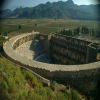

(100, 100, 3)


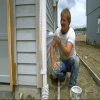

(100, 100, 3)


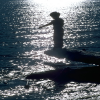

(100, 100, 3)


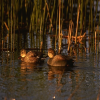

(100, 100, 3)


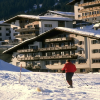

(100, 100, 3)


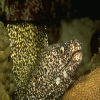

(100, 100, 3)


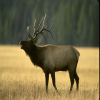

(100, 100, 3)


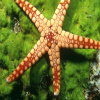

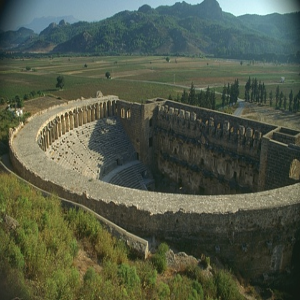

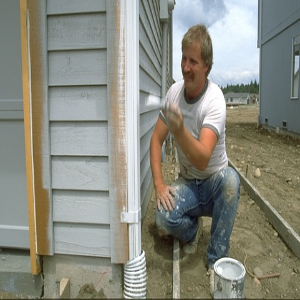

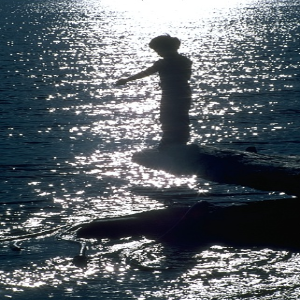

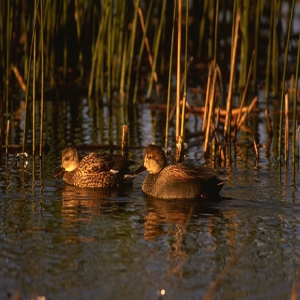

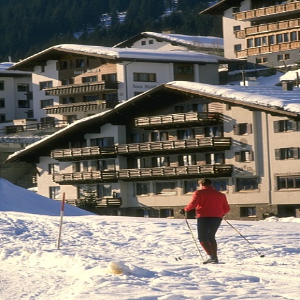

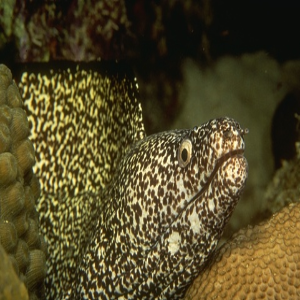

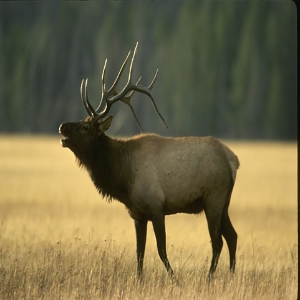

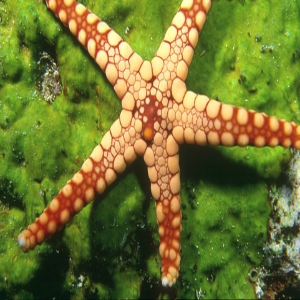

In [ ]:
for batch in train_ds_fin.take(1):
  for img in batch[0]:
    print(img.shape)
    display(array_to_img(img))
  for img in batch[1]:
    print(img.shape)
    display(array_to_img(img))

# Build a model

In [ ]:
def get_model(upscale_factor=3, channels=3):
  inputs = tf.keras.Input(shape=(None, None, channels))
  x = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(channels * (upscale_factor ** 2), (3, 3), activation='relu', padding='same')(x)
  outputs = tf.nn.depth_to_space(x, upscale_factor)
  model = tf.keras.Model(inputs, outputs)
  return model
model = get_model(upscale_factor=upscale_factor, channels=3)

# Define callbacks to monitor training

In [ ]:
def plot_results(img, prefix, title):
  """Plot the result with zoom-in area."""
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0

  # Create a new figure with a default 111 subplot.
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")

  plt.title(title)
  # zoom-factor: 2.0, location: upper-left
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin="lower")

  # Specify the limits.
  x1, x2, y1, y2 = 200, 300, 100, 200
  # Apply the x-limits.
  axins.set_xlim(x1, x2)
  # Apply the y-limits.
  axins.set_ylim(y1, y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  # Make the line.
  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()


def get_lowres_image(img, upscale_factor):
  """Return low-resolution image to use as model input."""
  new_img = img.resize((img.size[0] // upscale_factor,
              img.size[1] // upscale_factor),
              PIL.Image.BICUBIC,)
  return new_img

def upscale_image(model, img):
  """Predict the result based on input image and restore the image as RGB."""

  img = img_to_array(img)
  img = img.astype("float32") / 255.0

  inputs = np.expand_dims(img, axis=0)
  outputs = model.predict(inputs)

  output_img = outputs[0]
  output_img *= 255.0
  output_img = output_img.clip(0, 255)
  
  return output_img

In [ ]:
class ESPCNCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

  # Store PSNR value in each epoch.
  def on_epoch_begin(self, epoch, logs=None):
    self.psnr = []

  def on_epoch_end(self, epoch, logs=None):
    print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
    if epoch % 20 == 0:
      prediction = upscale_image(self.model, self.test_img)
      plot_results(prediction, "epoch-" + str(epoch), "prediction")

  def on_test_batch_end(self, batch, logs=None):
    self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor="loss",
  mode="min",
  save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=3)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    4864      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 27)    7803      
                                                                 
 tf.nn.depth_to_space_1 (TFO  (None, None, None, 3)    0         
 pLambda)                                                        
                                                           

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.


# Train the model

Epoch 1/100


2023-02-23 17:20:26.517302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Mean PSNR for epoch: 14.59


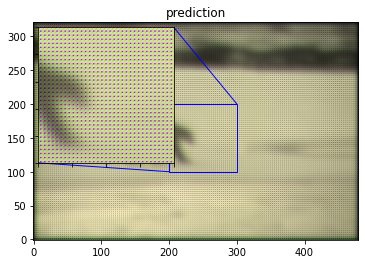

25/25 - 4s - loss: 0.0649 - val_loss: 0.0334 - 4s/epoch - 158ms/step
Epoch 2/100
Mean PSNR for epoch: 15.72
25/25 - 2s - loss: 0.0303 - val_loss: 0.0260 - 2s/epoch - 82ms/step
Epoch 3/100
Mean PSNR for epoch: 16.71
25/25 - 2s - loss: 0.0254 - val_loss: 0.0212 - 2s/epoch - 79ms/step
Epoch 4/100
Mean PSNR for epoch: 18.72
25/25 - 2s - loss: 0.0159 - val_loss: 0.0143 - 2s/epoch - 78ms/step
Epoch 5/100
Mean PSNR for epoch: 19.02
25/25 - 2s - loss: 0.0133 - val_loss: 0.0125 - 2s/epoch - 79ms/step
Epoch 6/100
Mean PSNR for epoch: 19.37
25/25 - 2s - loss: 0.0121 - val_loss: 0.0118 - 2s/epoch - 80ms/step
Epoch 7/100
Mean PSNR for epoch: 19.46
25/25 - 2s - loss: 0.0117 - val_loss: 0.0114 - 2s/epoch - 77ms/step
Epoch 8/100
Mean PSNR for epoch: 19.98
25/25 - 2s - loss: 0.0112 - val_loss: 0.0112 - 2s/epoch - 77ms/step
Epoch 9/100
Mean PSNR for epoch: 19.23
25/25 - 2s - loss: 0.0110 - val_loss: 0.0115 - 2s/epoch - 77ms/step
Epoch 10/100
Mean PSNR for epoch: 19.65
25/25 - 2s - loss: 0.0108 - val_los

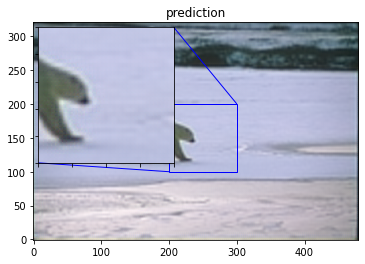

25/25 - 2s - loss: 0.0031 - val_loss: 0.0032 - 2s/epoch - 98ms/step
Epoch 22/100
Mean PSNR for epoch: 24.77
25/25 - 2s - loss: 0.0032 - val_loss: 0.0032 - 2s/epoch - 77ms/step
Epoch 23/100
Mean PSNR for epoch: 24.75
25/25 - 2s - loss: 0.0033 - val_loss: 0.0033 - 2s/epoch - 76ms/step
Epoch 24/100
Mean PSNR for epoch: 24.50
25/25 - 2s - loss: 0.0036 - val_loss: 0.0033 - 2s/epoch - 78ms/step
Epoch 25/100
Mean PSNR for epoch: 24.50
25/25 - 2s - loss: 0.0032 - val_loss: 0.0033 - 2s/epoch - 77ms/step
Epoch 26/100
Mean PSNR for epoch: 24.77
25/25 - 2s - loss: 0.0032 - val_loss: 0.0033 - 2s/epoch - 77ms/step
Epoch 27/100
Mean PSNR for epoch: 25.06
25/25 - 2s - loss: 0.0031 - val_loss: 0.0033 - 2s/epoch - 77ms/step
Epoch 28/100
Mean PSNR for epoch: 24.57
25/25 - 2s - loss: 0.0030 - val_loss: 0.0033 - 2s/epoch - 77ms/step
Epoch 29/100
Mean PSNR for epoch: 24.64
25/25 - 2s - loss: 0.0030 - val_loss: 0.0034 - 2s/epoch - 78ms/step
Epoch 30/100
Mean PSNR for epoch: 25.02
25/25 - 2s - loss: 0.0031 - 

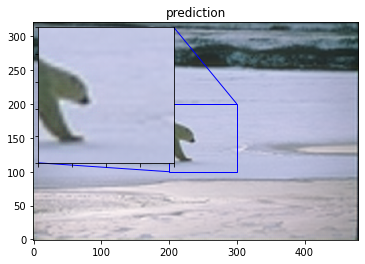

25/25 - 2s - loss: 0.0028 - val_loss: 0.0029 - 2s/epoch - 97ms/step
Epoch 42/100
Mean PSNR for epoch: 25.03
25/25 - 2s - loss: 0.0028 - val_loss: 0.0029 - 2s/epoch - 78ms/step
Epoch 43/100
Mean PSNR for epoch: 25.36
25/25 - 2s - loss: 0.0029 - val_loss: 0.0029 - 2s/epoch - 77ms/step
Epoch 44/100
Mean PSNR for epoch: 25.12
25/25 - 2s - loss: 0.0029 - val_loss: 0.0029 - 2s/epoch - 78ms/step
Epoch 45/100
Mean PSNR for epoch: 25.24
25/25 - 2s - loss: 0.0028 - val_loss: 0.0029 - 2s/epoch - 77ms/step
Epoch 46/100
Mean PSNR for epoch: 25.65
25/25 - 2s - loss: 0.0028 - val_loss: 0.0029 - 2s/epoch - 78ms/step
Epoch 47/100
Mean PSNR for epoch: 25.22
25/25 - 2s - loss: 0.0028 - val_loss: 0.0030 - 2s/epoch - 79ms/step
Epoch 48/100
Mean PSNR for epoch: 25.13
25/25 - 2s - loss: 0.0030 - val_loss: 0.0030 - 2s/epoch - 77ms/step
Epoch 49/100
Mean PSNR for epoch: 25.20
25/25 - 2s - loss: 0.0030 - val_loss: 0.0030 - 2s/epoch - 79ms/step
Epoch 50/100
Mean PSNR for epoch: 25.08
25/25 - 2s - loss: 0.0036 - 

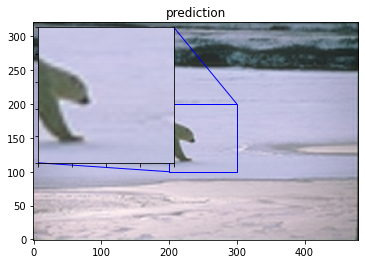

25/25 - 2s - loss: 0.0029 - val_loss: 0.0028 - 2s/epoch - 97ms/step
Epoch 62/100
Mean PSNR for epoch: 25.95
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 78ms/step
Epoch 63/100
Mean PSNR for epoch: 24.93
25/25 - 2s - loss: 0.0028 - val_loss: 0.0029 - 2s/epoch - 78ms/step
Epoch 64/100
Mean PSNR for epoch: 25.47
25/25 - 2s - loss: 0.0030 - val_loss: 0.0029 - 2s/epoch - 76ms/step
Epoch 65/100
Mean PSNR for epoch: 25.38
25/25 - 2s - loss: 0.0030 - val_loss: 0.0030 - 2s/epoch - 78ms/step
Epoch 66/100
Mean PSNR for epoch: 25.22
25/25 - 2s - loss: 0.0028 - val_loss: 0.0030 - 2s/epoch - 79ms/step
Epoch 67/100
Mean PSNR for epoch: 24.62
25/25 - 2s - loss: 0.0033 - val_loss: 0.0032 - 2s/epoch - 77ms/step
Epoch 68/100
Mean PSNR for epoch: 25.59
25/25 - 2s - loss: 0.0029 - val_loss: 0.0028 - 2s/epoch - 78ms/step
Epoch 69/100
Mean PSNR for epoch: 25.16
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 79ms/step
Epoch 70/100
Mean PSNR for epoch: 25.33
25/25 - 2s - loss: 0.0027 - 

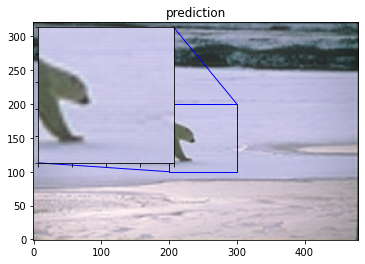

25/25 - 2s - loss: 0.0032 - val_loss: 0.0030 - 2s/epoch - 94ms/step
Epoch 82/100
Mean PSNR for epoch: 24.29
25/25 - 2s - loss: 0.0035 - val_loss: 0.0037 - 2s/epoch - 78ms/step
Epoch 83/100
Mean PSNR for epoch: 25.59
25/25 - 2s - loss: 0.0030 - val_loss: 0.0029 - 2s/epoch - 78ms/step
Epoch 84/100
Mean PSNR for epoch: 25.36
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 78ms/step
Epoch 85/100
Mean PSNR for epoch: 25.47
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 78ms/step
Epoch 86/100
Mean PSNR for epoch: 25.49
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 77ms/step
Epoch 87/100
Mean PSNR for epoch: 25.43
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 77ms/step
Epoch 88/100
Mean PSNR for epoch: 25.28
25/25 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 76ms/step


In [ ]:
epochs = 100

model.compile(optimizer=optimizer, loss=loss_fn)

model.fit(train_ds_fin, epochs=epochs, callbacks=callbacks,
     validation_data=valid_ds_fin, verbose=2)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# Run model prediction and plot the results

In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
  img = load_img(test_img_path)
  lowres_input = get_lowres_image(img, upscale_factor)
  w = lowres_input.size[0] * upscale_factor
  h = lowres_input.size[1] * upscale_factor
  highres_img = img.resize((w, h))
  prediction = upscale_image(model, lowres_input)
  lowres_img = lowres_input.resize((w, h))
  lowres_img_arr = img_to_array(lowres_img)
  highres_img_arr = img_to_array(highres_img)
  predict_img_arr = img_to_array(prediction)
  bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
  test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

  total_bicubic_psnr += bicubic_psnr
  total_test_psnr += test_psnr

  print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
  print("PSNR of predict and high resolution is %.4f" % test_psnr)
  plot_results(lowres_img, index, "lowres")
  plot_results(highres_img, index, "highres")
  plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.


PSNR of low resolution image and high resolution image is 30.0157
PSNR of predict and high resolution is 29.7850
PSNR of low resolution image and high resolution image is 25.1103
PSNR of predict and high resolution is 25.2130
PSNR of low resolution image and high resolution image is 27.7789
PSNR of predict and high resolution is 28.0664
PSNR of low resolution image and high resolution image is 28.0321
PSNR of predict and high resolution is 28.2284
PSNR of low resolution image and high resolution image is 25.7853
PSNR of predict and high resolution is 26.0337
PSNR of low resolution image and high resolution image is 25.9181
PSNR of predict and high resolution is 25.9930
PSNR of low resolution image and high resolution image is 26.2389
PSNR of predict and high resolution is 26.7197
PSNR of low resolution image and high resolution image is 23.3281
PSNR of predict and high resolution is 23.9910
PSNR of low resolution image and high resolution image is 29.9008
PSNR of predict and high resol

In [ ]:
model.save('SRCNN_rgb.h5')